In [1]:
import csaf.config as cconf
import csaf.system as csys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# create a csaf configuration out of toml
my_conf = cconf.SystemConfig.from_toml("/csaf-system/f16_multiagent_config.toml")

10:26:45 PM: (INFO)  setting up CSAF System from TOML file '/csaf-system/f16_multiagent_config.toml'
10:26:45 PM: (INFO)  Output Dir: /csaf-system/output
10:26:45 PM: (INFO)  Codec Dir: /csaf-system/codec
10:26:45 PM: (INFO)  Log Level: info


WARNING! log will output to file that already exists: '/csaf-system/output/f16run.log'


In [2]:
def air_collision_condition(ctraces):
        """ground collision premature termnation condition
        TODO: I had to alter the terminating conditions to support this expression
        """
        # get the aircraft states
        sa, sb = ctraces['planta']['states'], ctraces['plantb']['states']
        if sa and sb:
            # look at distance between last state
            return (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sb[-1][9:11]))) < 10

In [3]:
# create pub/sub components out of the configuration
my_system = csys.System.from_config(my_conf)

simulation_timespan = [0, 10.5]

In [4]:
# set the scenario states
my_system.set_state('planta', [500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000.0, 9.0])
my_system.set_state('plantb', [500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 6000.0, 9.0])

In [5]:
# simulate and collect time traces out of the components
trajs = my_system.simulate_tspan(simulation_timespan, 
                                 terminating_conditions_all=air_collision_condition,
                                 show_status=True)

# destroy components and unbind all used sockets
my_system.unbind() 

100%|██████████| 4416/4416 [00:09<00:00, 471.48it/s]


In [27]:
# Make a "fake" 3rd trajectory for the air balloon
# NOTE: eventually this will be simulated by a proper CSAF component
import copy
pe0 = -500.0
pn0 = 3750.0
pu0 = 6000.0

plantc = copy.deepcopy(trajs['planta'])
ctrlc = copy.deepcopy(trajs['controllera'])

# Hack to make the trajectory "static"
for idx in range(0,len(plantc.states)):
    # Static orientation
    plantc.states[idx][3] = 0.0
    plantc.states[idx][4] = 0.0
    plantc.states[idx][5] = 0.0
    # Fixed location
    plantc.states[idx][9] = pn0
    plantc.states[idx][10] = pe0
    plantc.states[idx][11] = pu0

# Insert into the `trajs` dictionary
trajs['plantc'] = plantc
trajs['controllerc'] = ctrlc

In [7]:
import sys
sys.path.append('/csaf-system')
from f16_plot import render_in_flightgear


In [42]:
# Create intruders
from components import fgnetfdm, fgimposter
f16b = fgimposter.FGMSImposter(callsign='F-16B', model_path='Aircraft/f16/Models/F-16.xml', fallback_model_index=516)
balloon = fgimposter.FGMSImposter(callsign='Balloon', model_path='Aircraft/Hot-Air-Balloon/Models/Hot-Air-Balloon.xml', fallback_model_index=702)
f16b.start()
balloon.start()

Starting main loop
Starting main loop


In [43]:
# Properly prepare the intruders
f16b.set_trajs(trajs['plantb'],trajs['controllerb'])
balloon.set_trajs(trajs['plantc'],trajs['controllerc'])

In [65]:
f16b.reset()
balloon.reset()

In [67]:
# Run the simulation
f16b.simulate(delta_t=0.5)
balloon.simulate(delta_t=0.5)
render_in_flightgear(trajs,nameSuffixes=['a'])

Done!


In [40]:
f16b.stop()
balloon.stop()

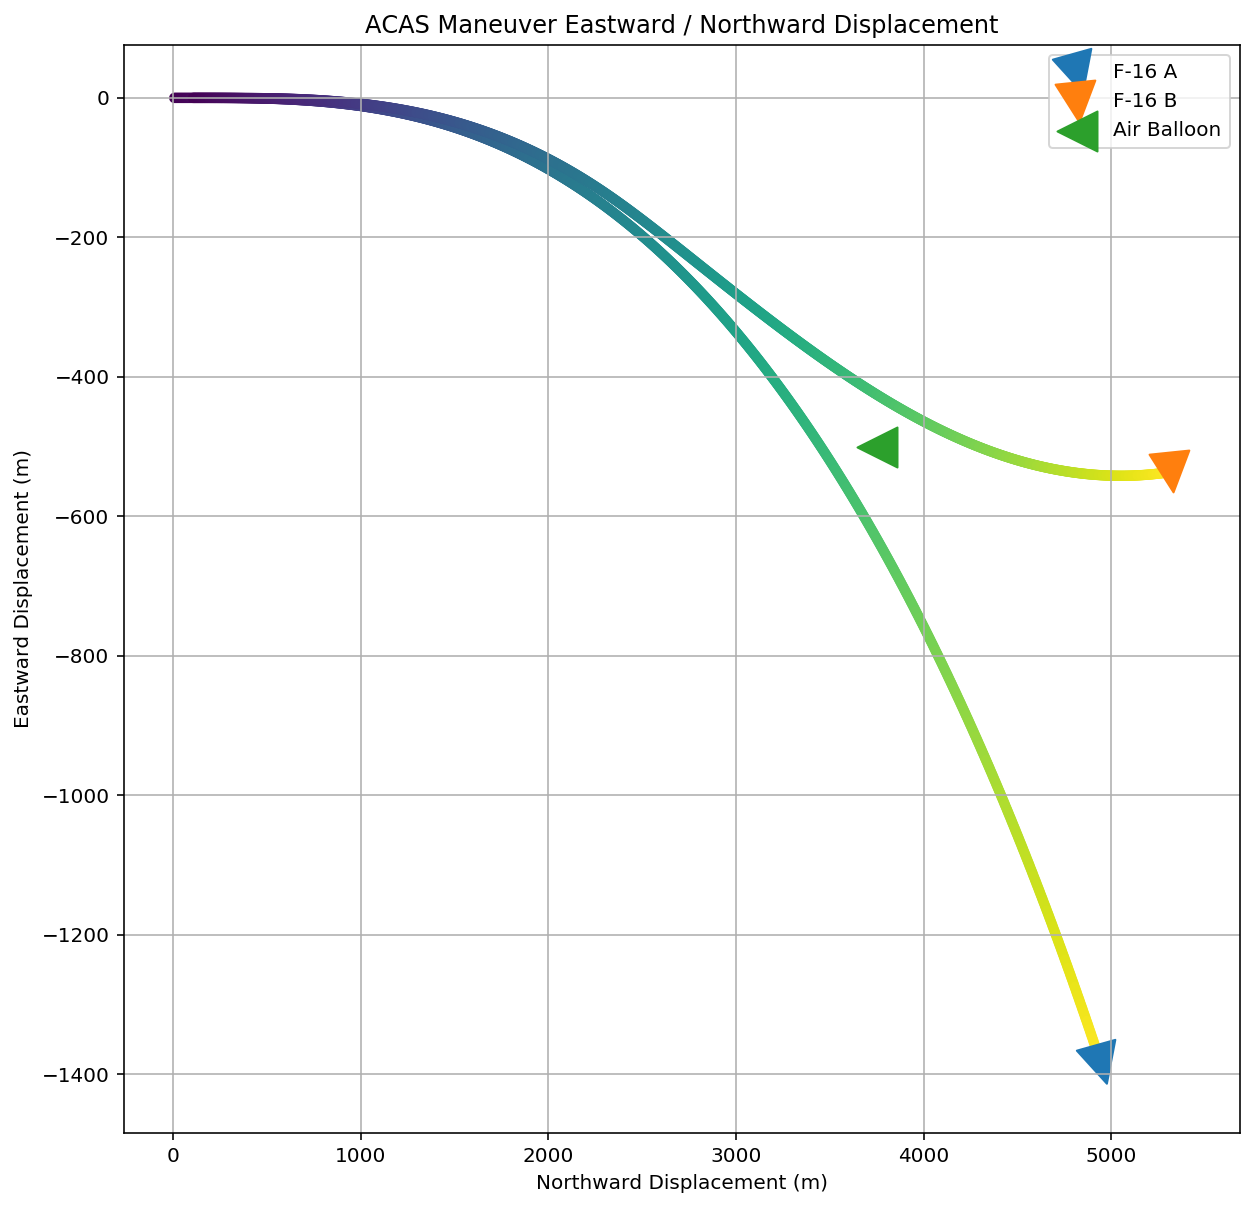

In [28]:
# plot the lateral trajectories
def add_airplane(posa, ax, label):
    t = mpl.markers.MarkerStyle(marker='^')
    a = np.arctan2(*(posa[-1]-posa[2])) + np.pi/2
    t._transform = t.get_transform().rotate_deg(np.rad2deg(a))
    plt.scatter(*posa[-1], marker=t, s=400, label=label)


posa = np.array(trajs['planta'].states)[:, 9:11]
posb = np.array(trajs['plantb'].states)[:, 9:11]
posc = np.array(trajs['plantc'].states)[:, 9:11]

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(*posa.T, linewidth=2, s=10, c=np.linspace(0, 1, len(posa)))
plt.scatter(*posb.T, linewidth=2, s=10, c=np.linspace(0, 1, len(posa)))
plt.scatter(*posc.T, linewidth=2, s=10, c=np.linspace(0, 1, len(posc)))

add_airplane(posa, plt.gca, label='F-16 A')
add_airplane(posb, plt.gca, label='F-16 B')
add_airplane(posc, plt.gca, label='Air Balloon')

plt.title('ACAS Maneuver Eastward / Northward Displacement')
plt.xlabel('Northward Displacement (m)')
plt.ylabel('Eastward Displacement (m)')
plt.legend()
plt.grid()